# SLAM Implementation

---

## Project Overview

In this project, we'll implement SLAM for robot that moves and senses in a 2 dimensional grid world.

SLAM gives us a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. This is an active area of research in the fields of robotics and autonomous systems. Since this localization and map-building relies on the visual sensing of landmarks, this is a computer vision problem. 

To implement SLAM algorithm we'll define a `slam` function, which takes in six parameters as input and returns the vector `mu`. 
This vector contains the locations of the robot as it moves and the positions of landmarks that it senses in the world. `mu` should have (x, y) coordinates interlaced, for example, if there were 2 poses and 2 landmarks, `mu` will look like the following, where `P` is the robot position and `L` the landmark position:
```
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])
```

It holds the poses first `(x0, y0), (x1, y1), ...,` then the landmark locations at the end of the matrix. We consider a `nx1` matrix to be a vector.

## Generating an environment

In a real SLAM problem we may be given a map that contains information about landmark locations, and in this example, we will make our own data using the `make_data` function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The `make_data` function relies on a correct implementation of robot move/sense functions in the `robot_class.py` file. The data is collected as an instantiated robot moves and senses in a world. Our SLAM function will take in this data as input. So, let's first create this data and explore how it represents the movement and sensor measurements that our robot takes.


The code below generates a world of a specified size with randomly generated landmark locations. `data` holds the sensors measurements and motion of our robot over time. It stores the measurements as `data[i][0]` and the motion as `data[i][1]`. The details of how `make_data` works can be found in the `helpers.py` file.

In [28]:
import numpy as np
from helpers import make_data

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot and generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[36, 25], [0, 15], [32, 83], [91, 11], [38, 78]]
Robot: [x=94.34090 y=9.70836]


### Understanding the `data` and `make_data`

The function `make_data` is responsible for instantiating a robot (using the robot class) and creating a grid world with landmarks in it. It also prints out the true location of landmarks and the *final* robot location, which we can refer back to when testing our implementation of SLAM.

The returned array holds information about **robot sensor measurements** and **robot motion** `(dx, dy)` collected over a number of time steps, `N`. We will have to use *only* these readings about motion and measurements to track a robot over time and find the determine the location of the landmarks using SLAM. 

The measurement and motion data can be accessed from the first and second index in the columns of the `data` array. For an example, for the i-th time step we can get it this way:
```
measurement = data[i][0]
motion = data[i][1]
```


In [29]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -12.692136309079405, -26.273099151321524], [2, -19.041883206550132, 33.7629403213698], [4, -12.548489393248012, 27.724542213429032]]


Example motion: 
 [-0.01912114526237479, -19.999990859543008]


When the value of `time_step` is changed, the list of measurements varies based on what in the world the robot sees after it moves. The robot can only sense so far and with a certain amount of accuracy in the measure of distance between its location and the location of landmarks. The motion of the robot is always a vector with two values: one for x and one for y displacement. 

## Constraint Initialization

One of the most challenging tasks here is to create and modify the constraint matrix and vector: omega and xi. They hold all the values defining the relationships between robot poses `xi` and landmark positions `Li`. Below is an example for 1D world, where omega is the blue matrix and xi is the pink vector.

<img src='images/motion_constraint.png' width=50% height=50% />


In a 2D world we are referring to robot poses as `Px, Py` and landmark positions as `Lx, Ly`. We can add *both* x and y locations in the constraint matrices:

<img src='images/constraints2D.png' width=50% height=50% />

Alrernatively, we may choose to create two of each omega and xi (one for x and one for y positions).

### A function to initialize omega and xi

The `initialize_constraints` function returns `omega` and `xi` constraints for the starting position of the robot. Any values that we do not yet know should be initialized with the value `0`. We assume that the robot starts out in exactly the middle of the world with 100% confidence (no motion or measurement noise at this point). The inputs `N` time steps, `num_landmarks`, and `world_size` give all the information needed to construct intial constraints of the correct size and starting values.

In [30]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    # Define and store the size (rows/cols) of the constraint matrix in a variable
    size = N + num_landmarks
    
    
    # Define the constraint matrix, Omega, with two initial "strength" values
    # for the initial x, y location of our robot
    
    omega_x = np.zeros((size, size))
    omega_x[0,0] = 1 # x0
    
    omega_y = np.zeros((size, size))
    omega_y[0,0] = 1 # y0
    
    # Define the constraint *vector*, xi assuming that the robot
    # starts out in the middle of the world with 100% confidence
    xi_x = np.zeros(size)
    xi_x[0] = world_size / 2.0
    
    xi_y = np.zeros(size)
    xi_y[0] = world_size / 2.0
    
    return omega_x, xi_x, omega_y, xi_y

### Test as we go

It's a good practice to test out the code as we go. Since `slam` relies on creating and updating constraint matrices, `omega` and `xi` to account for robot sensor measurements and motion, let's check that they initialize as expected for any given parameters.

The test code below allows to visualize the results of the `initialize_constraints` function. The [seaborn](https://seaborn.pydata.org/) library is used for visualization.

The constraints should vary in size with the number of time steps and landmarks as these values affect the number of poses a robot will take and landmark locations which relationships should be tracked in the constraint matrices. `omega` holds the weights of each variable and `xi` holds the value of the sum of these variables, as seen in Notebook 2. 

In [31]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [32]:
# define a small N and world_size (small for ease of visualization)
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
#initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)
initial_omega_x, initial_xi_x, initial_omega_y, initial_xi_y = initialize_constraints(N_test, num_landmarks_test, small_world)

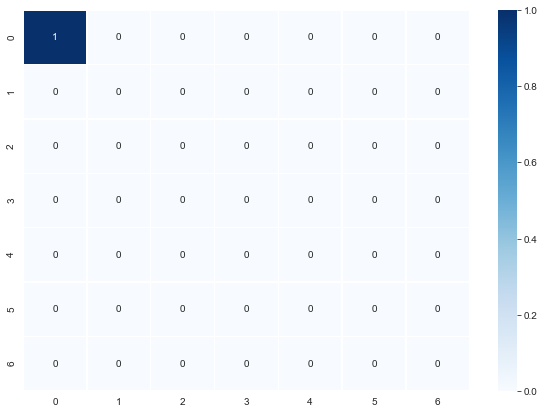

In [33]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
#sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)
sns.heatmap(DataFrame(initial_omega_x), cmap='Blues', annot=True, linewidths=.5)

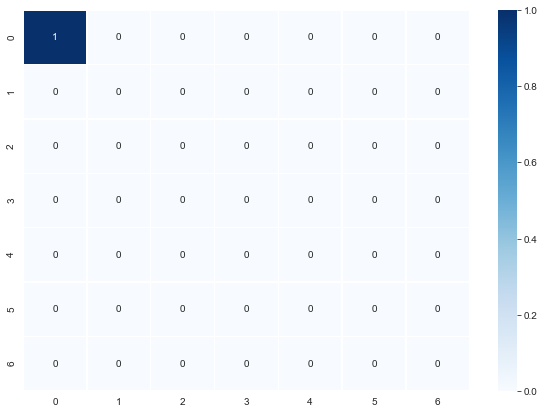

In [34]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
#sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)
sns.heatmap(DataFrame(initial_omega_y), cmap='Blues', annot=True, linewidths=.5)

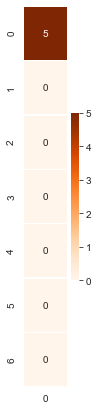

In [35]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
#sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)
sns.heatmap(DataFrame(initial_xi_x), cmap='Oranges', annot=True, linewidths=.5)

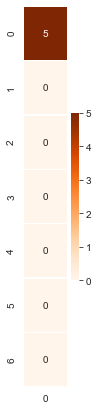

In [36]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
#sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)
sns.heatmap(DataFrame(initial_xi_y), cmap='Oranges', annot=True, linewidths=.5)

---
## SLAM inputs 

In addition to `data`, our `slam` function will also take in:
* N - The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (width and height) of the world
* motion_noise - The noise associated with motion
* measurement_noise - The noise associated with measurement/sensing





#### The effect of noise

Since `omega` holds the weights for each position variable, we can update these weights by accessing the correct index in omega `omega[row][col]` and adding/subtracting `1.0/noise` where `noise` is measurement or motion noise. `Xi` holds actual position values and to update `xi` we will do a similar addition process only using the actual value of a motion or measurement. Thus, for a vector index `xi[row][0]` we will end up adding/subtracting one measurement or motion divided by their respective `noise`.

### Graph SLAM Implementation


In order to implement Graph SLAM we need to construct equations from the constraint matrices `omega` and `xi`. The solution to these equations is the vector `mu`, which can be computed as the inverse of `omega` times `xi`: $\mu = \Omega^{-1}\xi$.

In [37]:
def update_matrix(omega, xi, i, j, d, noise):
    """
    Updates the omega matrix and vector xi with respect to the relationship between variables i and j.
    
    :param omega: The square matrix labeled with robot and landmark positions.
    :param xi: The vector defining the constant terms of the constraint equations.
    :param i: The positively-weighted variable index.
    :param j: The negatively-weighted variable index.
    :param d: The displacement between the variables i and j.
    :param noise: Either the motion or measurement noise, depending on the type of variables i and j.
    """
    # x[i] - x[j] = d    
    omega[i, i] += 1.0/noise            
    omega[i, j] -= 1.0/noise 
    xi[i] += d/noise

## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) and all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    ## Initialize constraint matrices, omega and xi
    omega_x, xi_x, omega_y, xi_y = initialize_constraints(N, num_landmarks, world_size)
    
    ## Iterate through each time step and use all the motion and measurement data to create constraints    
    
    for t in range(0, len(data)): # 0..N-2
    
        ## Update the constraint matrix/vector to account for all measurements
        ## (this is a series of additions that take into account the measurement noise)
        
        for lk_index, dx, dy in data[t][0]:
                        
            # x[t] + dx = Lx[lk_index]
                        
            update_matrix(omega_x, xi_x, t, N+lk_index, -dx, measurement_noise) # x[t] - Lx[i] = -dx 
            update_matrix(omega_x, xi_x, N+lk_index, t, dx, measurement_noise) # Lx[i] - x[t] = dx
            
            # y[t] + dx = Ly[lk_index]
            
            update_matrix(omega_y, xi_y, t, N+lk_index, -dy, measurement_noise)
            update_matrix(omega_y, xi_y, N+lk_index, t, dy, measurement_noise)
            
            
        ## Update the constraint matrix/vector to account for all motion and motion noise
        
        dx, dy = data[t][1]
        
        # x[t+1] = x[t] + dx       
        
        update_matrix(omega_x, xi_x, t, t+1, -dx, motion_noise) # x[t] - x[t+1] = -dx        
        update_matrix(omega_x, xi_x, t+1, t, dx, motion_noise) # x[t+1] - x[t] = dx
         
        # y[t+1] = y[t] + dy
        
        update_matrix(omega_y, xi_y, t, t+1, -dy, motion_noise)
        update_matrix(omega_y, xi_y, t+1, t, dy, motion_noise)
        
        
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    
    mu_x = np.dot(np.linalg.inv(omega_x), xi_x)
    mu_y = np.dot(np.linalg.inv(omega_y), xi_y)
        
    # Combine mu_x and mu_y into a single vector
    mu = np.ravel(np.column_stack((mu_x, mu_y)))
    
    return mu # return `mu`

## Helper functions

To check that our implementation of SLAM works for various inputs, we'll create two helper functions that display the estimated pose and landmark locations that `slam` function has produced. 


First, given a result `mu` and the number of time steps, `N`, we define a function that extracts robot poses and landmark locations and returns them as separate lists. 

In [38]:
# a helper function that creates a list of poses and of landmarks for ease of printing
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


Then, we define a function that nicely prints out these lists.

In [39]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


## Run SLAM

Once we've completed the implementation of `slam`, let's see what `mu` it returns for different world sizes and different landmarks.

We expect to see a result that displays two lists:

1. **Estimated poses**, a list of (x, y) pairs that is exactly `N` in length since this is how many motions our robot has taken. The very first pose should be the center of the world, e.g. `[50.000, 50.000]` for a world that is 100.0 in square size.

2. **Estimated landmarks**, a list of landmark positions (x, y) that is exactly `num_landmarks` in length. These values should be very similar to the printout of exact landmark locations, but not quite (since `slam` must account for noise in motion and measurement).

In [45]:
# call our implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[48.753, 30.519]
[49.154, 11.313]
[51.371, 31.258]
[53.069, 50.352]
[54.413, 69.708]
[56.727, 88.502]
[37.813, 79.296]
[19.187, 70.358]
[1.935, 62.355]
[21.424, 66.795]
[38.837, 71.319]
[58.233, 75.347]
[78.721, 79.154]
[97.822, 84.559]
[91.712, 66.126]
[85.602, 47.693]
[79.957, 27.239]
[74.450, 9.190]
[94.414, 10.392]


Estimated Landmarks:
[35.948, 24.198]
[2.269, 16.513]
[32.483, 83.162]
[91.935, 10.387]
[38.514, 77.335]


## Visualization

Using the `display_world` code from the `helpers.py` file (also used in the first notebook), we can actually visualize the results of `slam`: the final position of the robot and the positon of landmarks, created from only motion and measurement data.

Note that these values are very similar to the printed true landmark locations and final pose from our call to `make_data` early in this notebook.

Last pose:  (94.41358806531159, 10.392422191515132)


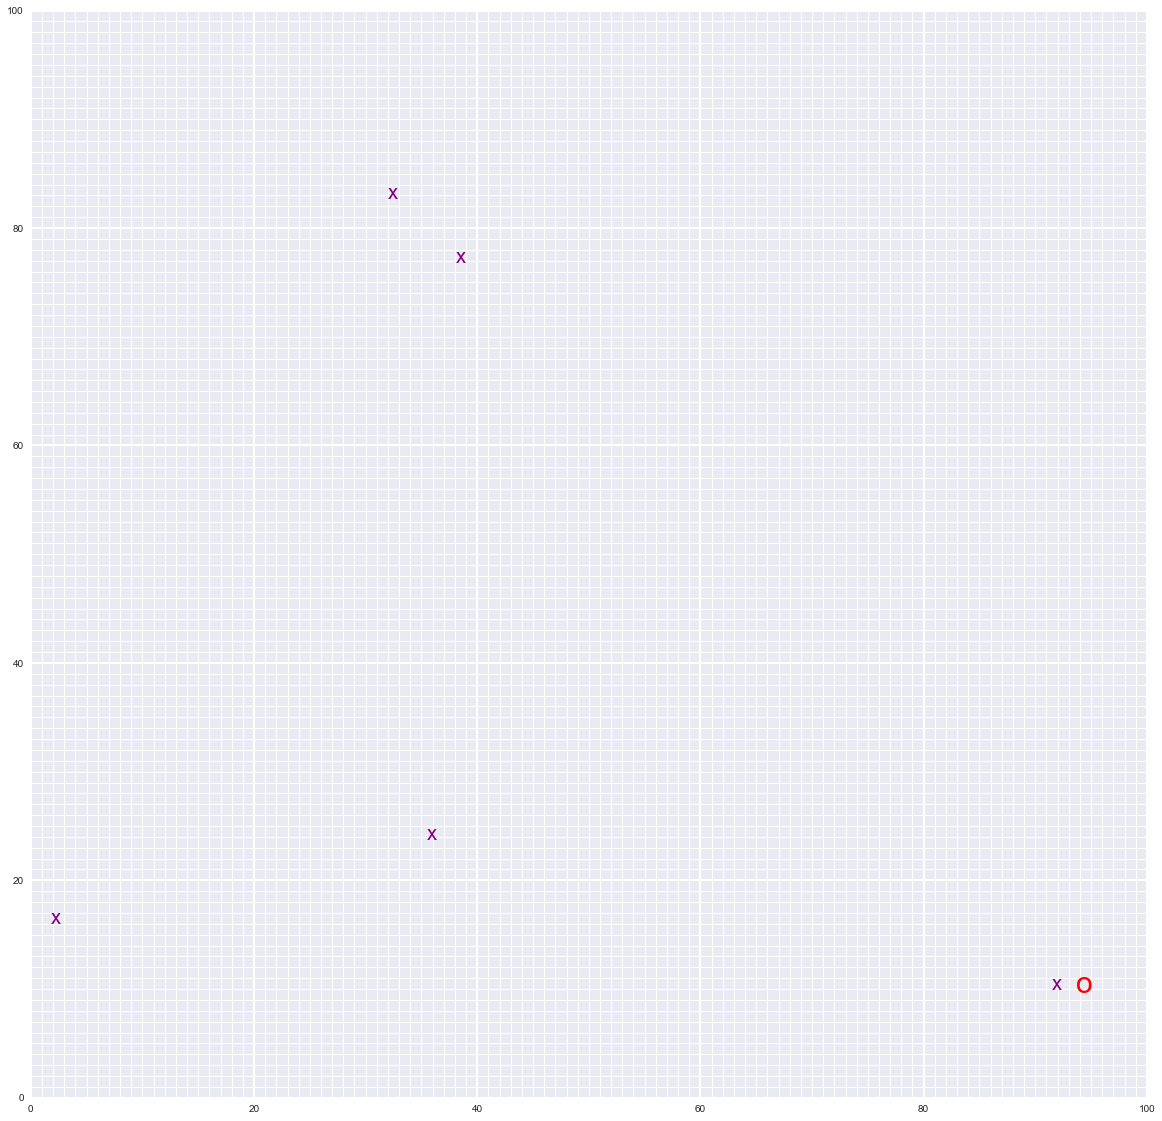

In [46]:
# import the helper function
from helpers import display_world

# Display the final world

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses have been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot and the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

## Credits

This project is based on the "Landmark Detection and Tracking" assignment from [Udacity Computer Vision Nanodegree](https://www.udacity.com/course/computer-vision-nanodegree--nd891).
